<a href="https://colab.research.google.com/github/Vonewman/Deep_Learning_models_with_pytorch/blob/master/Transfer_learning_for_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import library

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

## Load data

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'gdrive/MyDrive/hymenoptera_data/data/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images

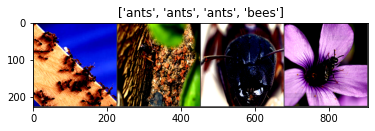

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = mean * inp + std
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

### Finetuning the convnet 

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4292 Acc: 0.8239
val Loss: 0.0001 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.2805 Acc: 0.8805
val Loss: 0.0000 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.3082 Acc: 0.8679
val Loss: 0.0000 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.4353 Acc: 0.8428
val Loss: 0.0000 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.4507 Acc: 0.7925
val Loss: 0.0223 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1804 Acc: 0.9182
val Loss: 0.0000 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.2590 Acc: 0.8931
val Loss: 0.0004 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.3777 Acc: 0.8994
val Loss: 0.0015 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.2545 Acc: 0.9434
val Loss: 0.0001 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1308 Acc: 0.9686
val Loss: 0.0000 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0673 Acc: 0.9937
val Loss: 0.0000 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.2119 Acc: 0.9308
val Loss: 0.0000 Acc: 1.0000

Ep

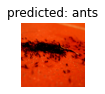

In [ ]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4917 Acc: 0.7610
val Loss: 0.0010 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.4306 Acc: 0.8176
val Loss: 0.0005 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.2654 Acc: 0.8868
val Loss: 0.0004 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.3945 Acc: 0.8679
val Loss: 0.0046 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.2742 Acc: 0.8742
val Loss: 0.0002 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.2765 Acc: 0.8868
val Loss: 0.0001 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.3729 Acc: 0.8176
val Loss: 0.0000 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.2447 Acc: 0.9119
val Loss: 0.0001 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.2052 Acc: 0.9182
val Loss: 0.0000 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.2226 Acc: 0.9057
val Loss: 0.0001 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2283 Acc: 0.8868
val Loss: 0.0001 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.2613 Acc: 0.9245
val Loss: 0.0001 Acc: 1.0000

Ep

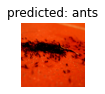

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()